# Stock Price Prediction Using RNNs

## Objective
The objective of this assignment is to try and predict the stock prices using historical data from four companies IBM (IBM), Google (GOOGL), Amazon (AMZN), and Microsoft (MSFT).

We use four different companies because they belong to the same sector: Technology. Using data from all four companies may improve the performance of the model. This way, we can capture the broader market sentiment.

The problem statement for this assignment can be summarised as follows:

> Given the stock prices of Amazon, Google, IBM, and Microsoft for a set number of days, predict the stock price of these companies after that window.

## Business Value

Data related to stock markets lends itself well to modeling using RNNs due to its sequential nature. We can keep track of opening prices, closing prices, highest prices, and so on for a long period of time as these values are generated every working day. The patterns observed in this data can then be used to predict the future direction in which stock prices are expected to move. Analyzing this data can be interesting in itself, but it also has a financial incentive as accurate predictions can lead to massive profits.

### **Data Description**

You have been provided with four CSV files corresponding to four stocks: AMZN, GOOGL, IBM, and MSFT. The files contain historical data that were gathered from the websites of the stock markets where these companies are listed: NYSE and NASDAQ. The columns in all four files are identical. Let's take a look at them:

- `Date`: The values in this column specify the date on which the values were recorded. In all four files, the dates range from Jaunary 1, 2006 to January 1, 2018.

- `Open`: The values in this column specify the stock price on a given date when the stock market opens.

- `High`: The values in this column specify the highest stock price achieved by a stock on a given date.

- `Low`: The values in this column specify the lowest stock price achieved by a stock on a given date.

- `Close`: The values in this column specify the stock price on a given date when the stock market closes.

- `Volume`: The values in this column specify the total number of shares traded on a given date.

- `Name`: This column gives the official name of the stock as used in the stock market.

There are 3019 records in each data set. The file names are of the format `\<company_name>_stock_data.csv`.

## **1 Data Loading and Preparation** <font color =red> [25 marks] </font>

#### **Import Necessary Libraries**

In [33]:
# Import libraries

# Stock Price Prediction using RNN Variants

from functools import reduce
from itertools import product
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

### **1.1 Data Aggregation** <font color =red> [7 marks] </font>

As we are using the stock data for four different companies, we need to create a new DataFrame that contains the combined data from all four data frames. We will create a function that takes in a list of the file names for the four CSV files, and returns a single data frame. This function performs the following tasks:
- Extract stock names from file names
- Read the CSV files as data frames
- Append the stock names into the columns of their respective data frames
- Drop unnecessary columns
- Join the data frames into one.

#### **1.1.1** <font color =red> [5 marks] </font>
Create the function to join DataFrames and use it to combine the four datasets.

In [34]:
# Define a function to load data and aggregate them

def merge_stock_data(file_paths):
    def load_and_rename(file_path):
        # Extract ticker from filename
        ticker = os.path.basename(file_path).split('_')[0].upper()

        # Read the CSV
        df = pd.read_csv(file_path, parse_dates=['Date'])

        # Select only necessary columns
        required_cols = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
        df = df[[col for col in required_cols if col in df.columns]]

        # Rename stock-specific columns
        rename_cols = {
            'Open': f'{ticker}_Open',
            'High': f'{ticker}_High',
            'Low': f'{ticker}_Low',
            'Close': f'{ticker}_Close',
            'Volume': f'{ticker}_Volume'
        }
        df = df.rename(columns=rename_cols)
        return df

    # Load and rename all dataframes
    dfs = [load_and_rename(fp) for fp in file_paths]

    # Merge on Date column
    merged_df = reduce(lambda left, right: pd.merge(left, right, on='Date', how='outer'), dfs)

    return merged_df

In [35]:
# Specify the names of the raw data files to be read and use the aggregation function to read the files
file_paths = [
    '/content/AMZN_stocks_data.csv',
    '/content/GOOGL_stocks_data.csv',
    '/content/IBM_stocks_data.csv',
    '/content/MSFT_stocks_data.csv'
]

merged_stocks_df = merge_stock_data(file_paths)
print(merged_stocks_df.head())


        Date  AMZN_Open  AMZN_High  AMZN_Low  AMZN_Close  AMZN_Volume  \
0 2006-01-03      47.47      47.85     46.25       47.58    7582127.0   
1 2006-01-04      47.48      47.73     46.69       47.25    7440914.0   
2 2006-01-05      47.16      48.20     47.11       47.65    5417258.0   
3 2006-01-06      47.97      48.58     47.32       47.87    6154285.0   
4 2006-01-09      46.55      47.10     46.40       47.08    8945056.0   

   GOOGL_Open  GOOGL_High  GOOGL_Low  GOOGL_Close  ...  IBM_Open  IBM_High  \
0      211.47      218.05     209.32       217.83  ...     82.45     82.55   
1      222.17      224.70     220.09       222.84  ...     82.20     82.50   
2      223.22      226.00     220.97       225.85  ...     81.40     82.90   
3      228.66      235.49     226.85       233.06  ...     83.95     85.03   
4      233.44      236.94     230.70       233.68  ...     84.10     84.25   

   IBM_Low  IBM_Close  IBM_Volume  MSFT_Open  MSFT_High  MSFT_Low  MSFT_Close  \
0    80.81 

In [36]:
# View specifics of the data

print("\nShape is given below --")
print(merged_stocks_df.shape)
print("\nInfo:")
print(merged_stocks_df.info())
print("\nSummary Statistics:")
print(merged_stocks_df.describe())


Shape is given below --
(3020, 21)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3020 entries, 0 to 3019
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          3020 non-null   datetime64[ns]
 1   AMZN_Open     3019 non-null   float64       
 2   AMZN_High     3019 non-null   float64       
 3   AMZN_Low      3019 non-null   float64       
 4   AMZN_Close    3019 non-null   float64       
 5   AMZN_Volume   3019 non-null   float64       
 6   GOOGL_Open    3019 non-null   float64       
 7   GOOGL_High    3019 non-null   float64       
 8   GOOGL_Low     3019 non-null   float64       
 9   GOOGL_Close   3019 non-null   float64       
 10  GOOGL_Volume  3019 non-null   float64       
 11  IBM_Open      3019 non-null   float64       
 12  IBM_High      3020 non-null   float64       
 13  IBM_Low       3019 non-null   float64       
 14  IBM_Close     3020 non-null   float64       


#### **1.1.2** <font color =red> [2 marks] </font>
Identify and handle any missing values.

In [37]:
# Handle Missing Values

# Sort by date just in case
merged_stocks_df.sort_values(by='Date', inplace=True)
merged_stocks_df.reset_index(drop=True, inplace=True)

print("Checking for Null values --")
print(merged_stocks_df.isnull().sum())

print("\nRows with missing values -- ")
print(merged_stocks_df[merged_stocks_df.isnull().any(axis=1)])

# For missing values check the data with near by dates
merged_stocks_df[
    (merged_stocks_df["Date"] >= pd.to_datetime('2017-07-25')) &
    (merged_stocks_df["Date"] <= pd.to_datetime('2017-08-05'))
][["Date","IBM_Open", "IBM_Low","IBM_Close","IBM_High"]]

# Drop the row with mostly missing values
merged_stocks_df.drop(index=1068, inplace=True)
merged_stocks_df.reset_index(drop=True, inplace=True)

# Fill missing IBM values for row 2913 using forward fill
merged_stocks_df = merged_stocks_df.fillna(method='ffill')

print("\nShape after droping the record -- ")
print(merged_stocks_df.shape)

print("\n Again checking for Null values --")
print(merged_stocks_df.isnull().sum())

# For missing values check the data together with near by dates
merged_stocks_df[
    (merged_stocks_df["Date"] >= pd.to_datetime('2017-07-25')) &
    (merged_stocks_df["Date"] <= pd.to_datetime('2017-08-05'))
][["Date","IBM_Open", "IBM_Low","IBM_Close","IBM_High"]]

Checking for Null values --
Date            0
AMZN_Open       1
AMZN_High       1
AMZN_Low        1
AMZN_Close      1
AMZN_Volume     1
GOOGL_Open      1
GOOGL_High      1
GOOGL_Low       1
GOOGL_Close     1
GOOGL_Volume    1
IBM_Open        1
IBM_High        0
IBM_Low         1
IBM_Close       0
IBM_Volume      0
MSFT_Open       1
MSFT_High       1
MSFT_Low        1
MSFT_Close      1
MSFT_Volume     1
dtype: int64

Rows with missing values -- 
           Date  AMZN_Open  AMZN_High  AMZN_Low  AMZN_Close  AMZN_Volume  \
1068 2010-04-01        NaN        NaN       NaN         NaN          NaN   
2913 2017-07-31    1019.05    1019.05    987.02      987.78    7352063.0   

      GOOGL_Open  GOOGL_High  GOOGL_Low  GOOGL_Close  ...  IBM_Open  IBM_High  \
1068         NaN         NaN        NaN          NaN  ...    128.95    129.31   
2913       960.0      961.19     941.72        945.5  ...       NaN    144.93   

      IBM_Low  IBM_Close  IBM_Volume  MSFT_Open  MSFT_High  MSFT_Low  \
1068  

<ipython-input-37-4908ce661d51>:24: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_stocks_df = merged_stocks_df.fillna(method='ffill')


Date  IBM_Open  IBM_Low  IBM_Close  IBM_High
2908 2017-07-25    146.57   146.03     146.19    147.49
2909 2017-07-26    146.27   144.47     145.36    146.46
2910 2017-07-27    145.00   143.64     145.07    145.40
2911 2017-07-28    144.81   143.84     144.29    145.04
2912 2017-07-31    144.81   143.84     144.67    144.93
2913 2017-08-01    145.00   144.72     145.30    145.67
2914 2017-08-02    145.12   144.22     144.45    145.29
2915 2017-08-03    144.43   144.43     144.94    145.34
2916 2017-08-04    145.00   144.40     145.16    145.39

### **1.2 Analysis and Visualisation** <font color =red> [5 marks] </font>

#### **1.2.1** <font color =red> [2 marks] </font>
Analyse the frequency distribution of stock volumes of the companies and also see how the volumes vary over time.

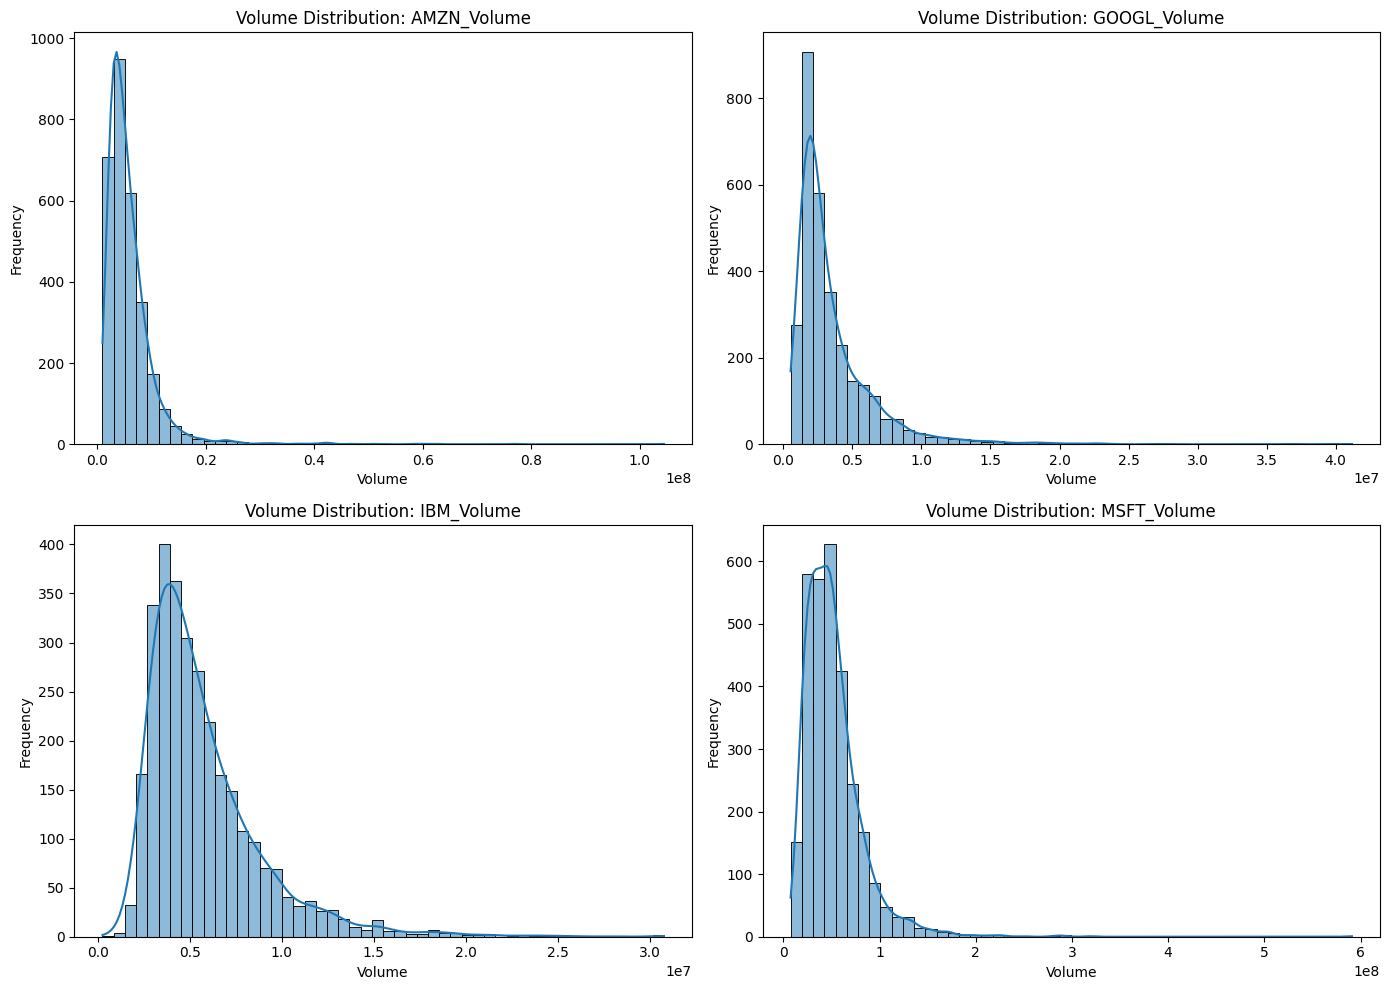

In [38]:
# Frequency distribution of volumes

volume_cols = ['AMZN_Volume', 'GOOGL_Volume', 'IBM_Volume', 'MSFT_Volume']

plt.figure(figsize=(14, 10))
for i, col in enumerate(volume_cols, 1):
    plt.subplot(2, 2, i)
    sns.histplot(merged_stocks_df[col], bins=50, kde=True)
    plt.title(f'Volume Distribution: {col}')
    plt.xlabel('Volume')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


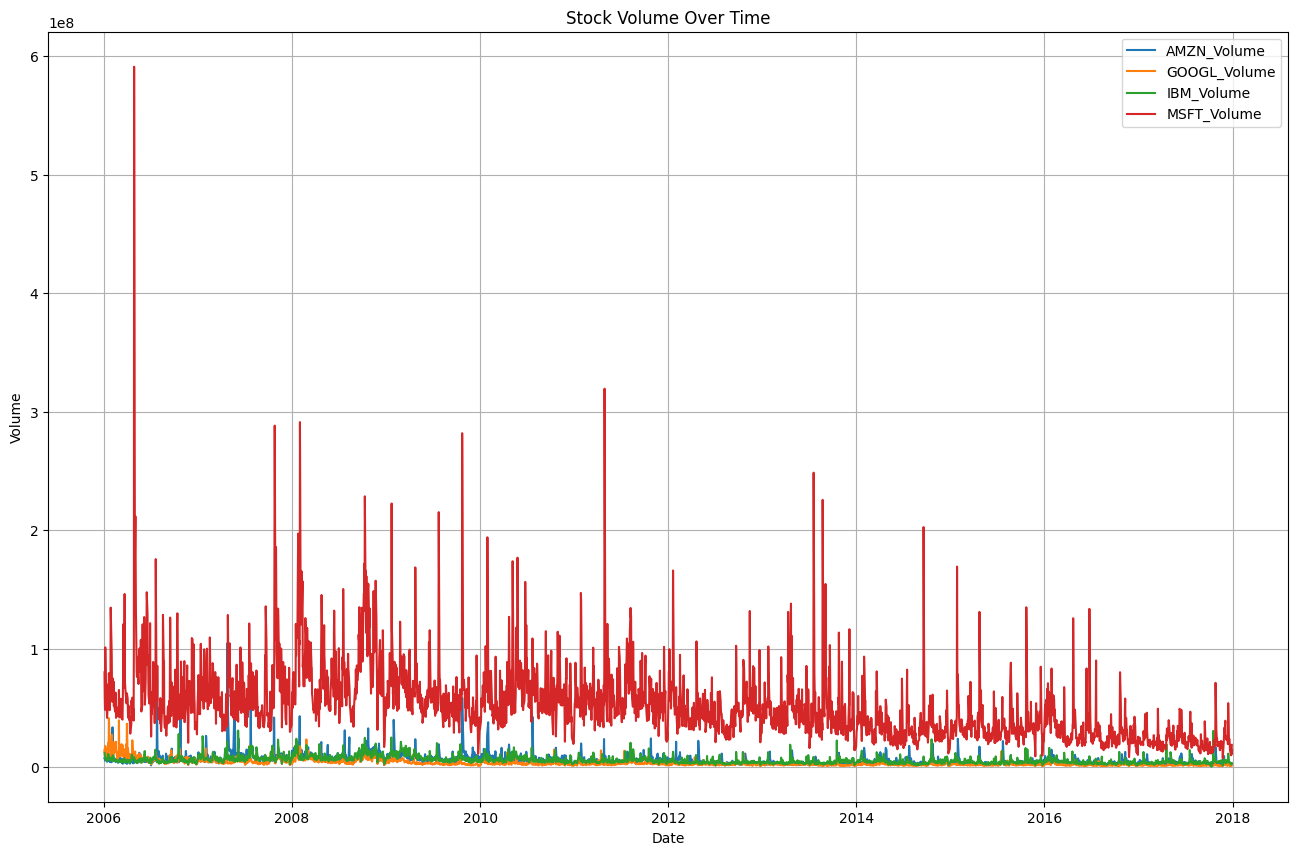

In [39]:
# Stock volume variation over time

plt.figure(figsize=(16, 10))
for col in volume_cols:
    plt.plot(merged_stocks_df['Date'], merged_stocks_df[col], label=col)
plt.title('Stock Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.show()

#To smooth the plot and remove daily noise, using rolling average:
plt.figure(figsize=(16, 10))
for col in volume_cols:
    plt.plot(
        merged_stocks_df['Date'],
        merged_stocks_df[col].rolling(window=30).mean(),  # 30-day average
        label=f'{col} (30-day MA)'
    )
plt.title('30-Day Rolling Average of Volume')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.show()

#### **1.2.2** <font color =red> [3 marks] </font>
Analyse correlations between features.

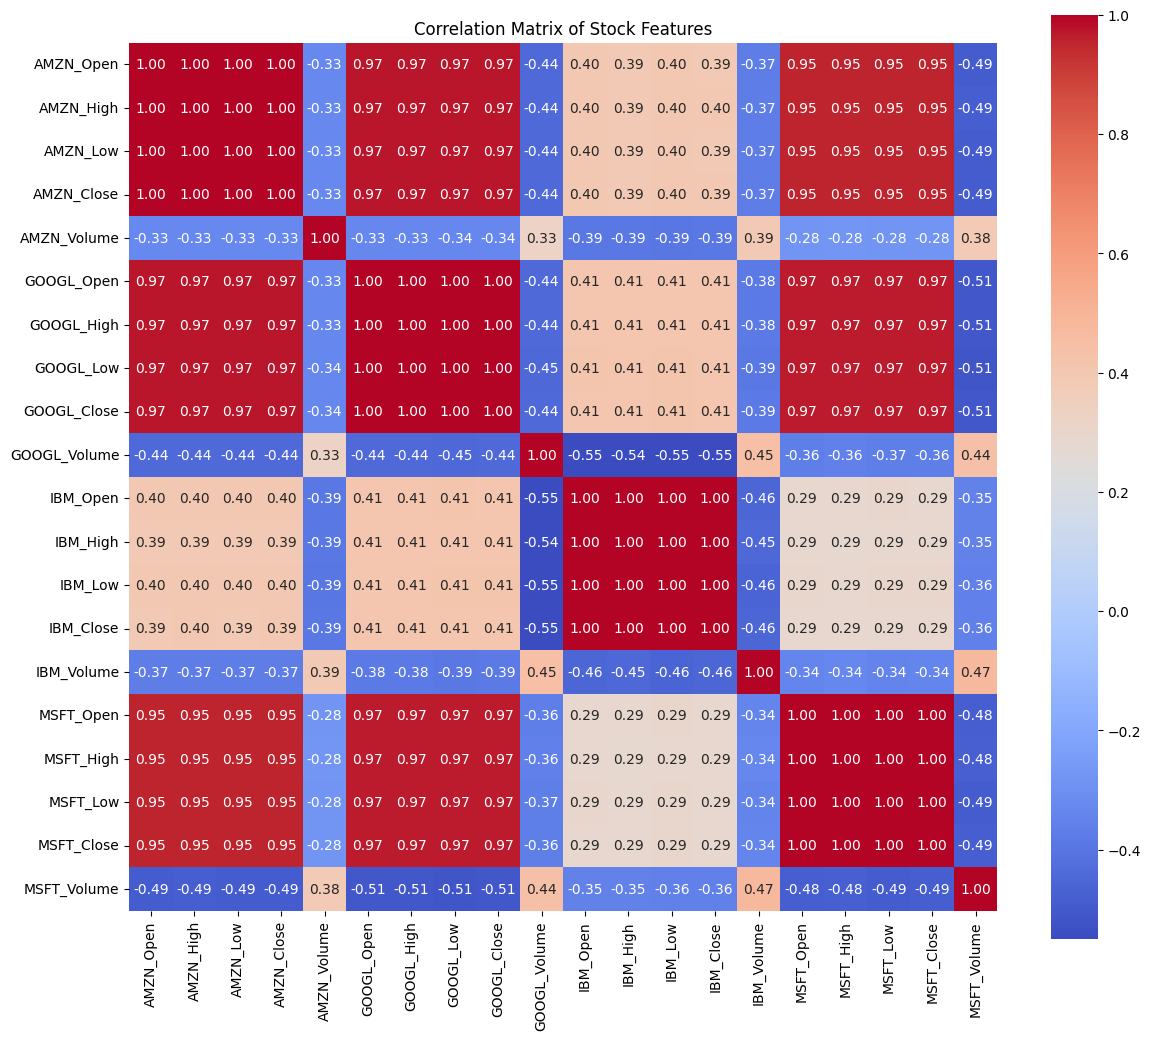

In [40]:
# Analyse correlations

correlation_matrix = merged_stocks_df.corr(numeric_only=True)

plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Correlation Matrix of Stock Features')
plt.show()

### **1.3 Data Processing** <font color =red> [13 marks] </font>

Next, we need to process the data so that it is ready to be used in recurrent neural networks. You know RNNs are suitable to work with sequential data where patterns repeat at regular intervals.

For this, we need to execute the following steps:
1. Create windows from the master data frame and obtain windowed `X` and corresponding windowed `y` values
2. Perform train-test split on the windowed data
3. Scale the data sets in an appropriate manner

We will define functions for the above steps that finally return training and testing data sets that are ready to be used in recurrent neural networks.

**Hint:** If we use a window of size 3, in the first window, the rows `[0, 1, 2]` will be present and will be used to predict the value of `CloseAMZN` in row `3`. In the second window, rows `[1, 2, 3]` will be used to predict `CloseAMZN` in row `4`.

#### **1.3.1** <font color =red> [3 marks] </font>
Create a function that returns the windowed `X` and `y` data.

From the main DataFrame, this function will create windowed DataFrames, and store those as a list of DataFrames.

Controllable parameters will be window size, step size (window stride length) and target names as a list of the names of stocks whose closing values we wish to predict.

In [41]:
# Define a function that divides the data into windows and generates target variable values for each window

def generate_sliding_windows(df, window_size=20, target_stocks=["AMZN", "GOOGL", "IBM", "MSFT"]):
    """
    Splits a stock DataFrame into sliding windows and generates next-day close price targets.

    Parameters:
        df (pd.DataFrame): The cleaned stock DataFrame with datetime index or 'Date' column.
        window_size (int): Number of days to include in each window.
        target_stocks (list): Tickers to generate targets for (default = all four).

    Returns:
        X (np.array): Feature windows (shape: [samples, window_size, features]).
        y (np.array): Target close prices for next day (shape: [samples, num_targets]).
    """
    df = df.drop(columns=["Date"], errors="ignore")  # Drop date for numeric modeling

    feature_cols = df.columns.tolist()
    target_cols = [f"{stock}_Close" for stock in target_stocks]

    X = []
    y = []

    for i in range(len(df) - window_size):
        window = df.iloc[i:i + window_size].values
        target = df.iloc[i + window_size][target_cols].values
        X.append(window)
        y.append(target)

    return np.array(X), np.array(y)

#### **1.3.2** <font color =red> [3 marks] </font>
Create a function to scale the data.

Define a function that will scale the data.

For scaling, we have to look at the whole length of data to find max/min values or standard deviations and means. If we scale the whole data at once, this will lead to data leakage in the windows. This is not necessarily a problem if the model is trained on the complete data with cross-validation.

One way to scale when dealing with windowed data is to use the `partial_fit()` method.
```
scaler.partial_fit(window)
scaler.transform(window)
```
You may use any other suitable way to scale the data properly. Arrive at a reasonable way to scale your data.

In [42]:
# Define a function that scales the windowed data
# The function takes in the windowed data sets and returns the scaled windows

def scale_windowed_data(X, y=None):
    """
    Scales 3D windowed input data (and optionally targets) using MinMaxScaler.

    Parameters:
        X (np.array): Input features of shape (samples, timesteps, features)
        y (np.array): Optional target array of shape (samples, num_targets)

    Returns:
        X_scaled (np.array): Scaled version of X
        y_scaled (np.array or None): Scaled y, if y was provided
        X_scaler (MinMaxScaler): Fitted scaler for X
        y_scaler (MinMaxScaler or None): Fitted scaler for y
    """
    num_samples, window_size, num_features = X.shape
    X_reshaped = X.reshape(-1, num_features)  # Shape: (samples * timesteps, features)

    X_scaler = MinMaxScaler()
    X_scaled = X_scaler.fit_transform(X_reshaped)
    X_scaled = X_scaled.reshape(num_samples, window_size, num_features)

    if y is not None:
        y_scaler = MinMaxScaler()
        y_scaled = y_scaler.fit_transform(y)
        return X_scaled, y_scaled, X_scaler, y_scaler
    else:
        return X_scaled, None, X_scaler, None


Next, define the main function that will call the windowing and scaling helper functions.

The input parameters for this function are:
- The joined master data set
- The names of the stocks that we wish to predict the *Close* prices for
- The window size
- The window stride
- The train-test split ratio

The outputs from this function are the scaled dataframes:
- *X_train*
- *y_train*
- *X_test*
- *y_test*

#### **1.3.3** <font color =red> [3 marks] </font>
Define a function to create windows of `window_size` and split the windowed data in to training and validation sets.

The function can take arguments such as list of target names, window size, window stride and split ratio. Use the windowing function here to make windows in the data and then perform scaling and train-test split.

In [43]:
# Define a function to create input and output data points from the master DataFrame

def prepare_train_val_sets(
    df,
    target_stocks=["AMZN", "GOOGL", "IBM", "MSFT"],
    window_size=20,
    window_stride=1,
    split_ratio=0.8
):
    """
    Prepares windowed, scaled train and validation sets from stock data.

    Parameters:
        df (pd.DataFrame): Cleaned stock data including 'Date' column.
        target_stocks (list): List of stock tickers to predict.
        window_size (int): Number of days in each input window.
        window_stride (int): Gap between consecutive windows (currently not used in base logic).
        split_ratio (float): Train-validation split ratio.

    Returns:
        X_train, X_val, y_train, y_val: Windowed and scaled data
        X_scaler, y_scaler: Scalers used for inverse transformation
    """
    # Step 1: Generate windowed features and targets
    X, y = generate_sliding_windows(df.copy(), window_size=window_size, target_stocks=target_stocks)

    # Step 2: Scale the data
    X_scaled, y_scaled, X_scaler, y_scaler = scale_windowed_data(X, y)

    # Step 3: Train-validation split
    split_index = int(len(X_scaled) * split_ratio)
    X_train, X_val = X_scaled[:split_index], X_scaled[split_index:]
    y_train, y_val = y_scaled[:split_index], y_scaled[split_index:]

    return X_train, X_val, y_train, y_val, X_scaler, y_scaler

We can now use these helper functions to create our training and testing data sets. But first we need to decide on a length of windows. As we are doing time series prediction, we want to pick a sequence that shows some repetition of patterns.

For selecting a good sequence length, some business understanding will help us. In financial scenarios, we can either work with business days, weeks (which comprise of 5 working days), months, or quarters (comprising of 13 business weeks). Try looking for some patterns for these periods.

#### **1.3.4** <font color =red> [2 marks] </font>
Identify an appropriate window size.

For this, you can use plots to see how target variable is varying with time. Try dividing it into parts by weeks/months/quarters.

In [44]:
# Checking for patterns in different sequence lengths

# For inline plotting
%matplotlib inline

# Resample the data to different time intervals (e.g., weekly, monthly, quarterly)
stocks_analysis_df = merged_stocks_df.copy()
stocks_analysis_df['Date'] = pd.to_datetime(stocks_analysis_df['Date'])
stocks_analysis_df.set_index('Date', inplace=True)

# Resample for weekly, monthly, and quarterly
df_weekly = stocks_analysis_df.resample('W').mean()
df_monthly = stocks_analysis_df.resample('M').mean()
df_quarterly = stocks_analysis_df.resample('Q').mean()

# Plot the stock prices
plt.figure(figsize=(12, 6))

# Amazon stock prices
plt.subplot(2, 2, 1)
plt.plot(stocks_analysis_df['AMZN_Close'], label='Daily')
plt.plot(df_weekly['AMZN_Close'], label='Weekly', linestyle='--')
plt.plot(df_monthly['AMZN_Close'], label='Monthly', linestyle='-.')
plt.plot(df_quarterly['AMZN_Close'], label='Quarterly', linestyle=':')
plt.title("AMZN Close Price over Time")
plt.legend()

# Google stock prices
plt.subplot(2, 2, 2)
plt.plot(stocks_analysis_df['GOOGL_Close'], label='Daily')
plt.plot(df_weekly['GOOGL_Close'], label='Weekly', linestyle='--')
plt.plot(df_monthly['GOOGL_Close'], label='Monthly', linestyle='-.')
plt.plot(df_quarterly['GOOGL_Close'], label='Quarterly', linestyle=':')
plt.title("GOOGL Close Price over Time")
plt.legend()

# IBM stock prices
plt.subplot(2, 2, 3)
plt.plot(stocks_analysis_df['IBM_Close'], label='Daily')
plt.plot(df_weekly['IBM_Close'], label='Weekly', linestyle='--')
plt.plot(df_monthly['IBM_Close'], label='Monthly', linestyle='-.')
plt.plot(df_quarterly['IBM_Close'], label='Quarterly', linestyle=':')
plt.title("IBM Close Price over Time")
plt.legend()

# Microsoft stock prices
plt.subplot(2, 2, 4)
plt.plot(stocks_analysis_df['MSFT_Close'], label='Daily')
plt.plot(df_weekly['MSFT_Close'], label='Weekly', linestyle='--')
plt.plot(df_monthly['MSFT_Close'], label='Monthly', linestyle='-.')
plt.plot(df_quarterly['MSFT_Close'], label='Quarterly', linestyle=':')
plt.title("MSFT Close Price over Time")
plt.legend()

plt.tight_layout()
plt.show()

<ipython-input-44-f394dd8fda29>:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = stocks_analysis_df.resample('M').mean()
<ipython-input-44-f394dd8fda29>:14: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  df_quarterly = stocks_analysis_df.resample('Q').mean()


#### **1.3.5** <font color =red> [2 marks] </font>
Call the functions to create testing and training instances of predictor and target features.

In [45]:
# Create data instances from the master data frame using decided window size and window stride

# Set parameters
window_size = 20
window_stride = 1  # Note: window_stride is currently not implemented in generate_sliding_windows
#target_stocks = ["AMZN", "GOOGL", "IBM", "MSFT"]
target_stocks = ["AMZN"]
split_ratio = 0.8  # 80% for training, 20% for validation

# Create train and validation sets
X_train, X_val, y_train, y_val, X_scaler, y_scaler = prepare_train_val_sets(
    df=merged_stocks_df,
    target_stocks=target_stocks,
    window_size=window_size,
    window_stride=window_stride,
    split_ratio=split_ratio
)


In [46]:
# Check the number of data points generated

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")

X_train shape: (2399, 20, 20)
X_val shape: (600, 20, 20)
y_train shape: (2399, 1)
y_val shape: (600, 1)


**Check if the training and testing datasets are in the proper format to feed into neural networks.**

In [15]:
# Check if the datasets are compatible inputs to neural networks

#As can be seen above the data sets are compatible with neural networks

## **2 RNN Models** <font color =red> [20 marks] </font>

In this section, we will:
- Define a function that creates a simple RNN
- Tune the RNN for different hyperparameter values
- View the performance of the optimal model on the test data

### **2.1 Simple RNN Model** <font color =red> [10 marks] </font>

#### **2.1.1** <font color =red> [3 marks] </font>
Create a function that builds a simple RNN model based on the layer configuration provided.

In [47]:
# Create a function that creates a simple RNN model according to the model configuration arguments

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam


def build_simple_rnn_model(input_shape, output_size,
                           rnn_units=50, dense_units=32,
                           dropout_rate=0.2, learning_rate=0.001):
    """
    Builds a simple RNN model using the given configuration.

    Parameters:
        input_shape (tuple): Shape of input (timesteps, features)
        output_size (int): Number of outputs (e.g., 4 for 4 stock predictions)
        rnn_units (int): Number of units in the SimpleRNN layer
        dense_units (int): Number of units in the dense hidden layer
        dropout_rate (float): Dropout rate after the RNN layer
        learning_rate (float): Learning rate for the optimizer

    Returns:
        model (tf.keras.Model): Compiled RNN model
    """
    model = Sequential()
    model.add(SimpleRNN(rnn_units, input_shape=input_shape, kernel_initializer='glorot_uniform'))            # helps with vanishing gradients
    model.add(Dropout(dropout_rate))
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dense(output_size))  # Linear output for regression

    optimizer = Adam(learning_rate=learning_rate, clipvalue=1.0)         # Clip gradients to prevent exploding
    model.compile(optimizer=optimizer, loss='mse')

    return model

#### **2.1.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [48]:
# Find an optimal configuration of simple RNN

# Grid search ranges
rnn_units_list = [32, 64, 128]
dense_units_list = [16, 32, 64]
dropout_list = [0.1, 0.3, 0.5]
learning_rate_list = [0.001, 0.005]

param_grid = list(product(rnn_units_list, dense_units_list, dropout_list, learning_rate_list))

best_model = None
best_val_loss = float('inf')
best_config = None
history_records = {}

for rnn_units, dense_units, dropout, lr in param_grid:
    print(f"Trying RNN={rnn_units}, Dense={dense_units}, Dropout={dropout}, LR={lr}")

    model = build_simple_rnn_model(
        input_shape=(X_train.shape[1], X_train.shape[2]),
        output_size=y_train.shape[1],
        rnn_units=rnn_units,
        dense_units=dense_units,
        dropout_rate=dropout,
        learning_rate=lr
    )

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=20,  # can increase if needed
        batch_size=32,
        verbose=0  # Turn off for clean output
    )

    val_loss = model.evaluate(X_val, y_val, verbose=0)
    history_records[(rnn_units, dense_units, dropout, lr)] = val_loss

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model
        best_config = (rnn_units, dense_units, dropout, lr)



Trying RNN=32, Dense=16, Dropout=0.1, LR=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Trying RNN=32, Dense=16, Dropout=0.1, LR=0.005
Trying RNN=32, Dense=16, Dropout=0.3, LR=0.001
Trying RNN=32, Dense=16, Dropout=0.3, LR=0.005
Trying RNN=32, Dense=16, Dropout=0.5, LR=0.001
Trying RNN=32, Dense=16, Dropout=0.5, LR=0.005
Trying RNN=32, Dense=32, Dropout=0.1, LR=0.001
Trying RNN=32, Dense=32, Dropout=0.1, LR=0.005
Trying RNN=32, Dense=32, Dropout=0.3, LR=0.001
Trying RNN=32, Dense=32, Dropout=0.3, LR=0.005
Trying RNN=32, Dense=32, Dropout=0.5, LR=0.001
Trying RNN=32, Dense=32, Dropout=0.5, LR=0.005
Trying RNN=32, Dense=64, Dropout=0.1, LR=0.001
Trying RNN=32, Dense=64, Dropout=0.1, LR=0.005
Trying RNN=32, Dense=64, Dropout=0.3, LR=0.001
Trying RNN=32, Dense=64, Dropout=0.3, LR=0.005
Trying RNN=32, Dense=64, Dropout=0.5, LR=0.001
Trying RNN=32, Dense=64, Dropout=0.5, LR=0.005
Trying RNN=64, Dense=16, Dropout=0.1, LR=0.001
Trying RNN=64, Dense=16, Dropout=0.1, LR=0.005
Trying RNN=64, Dense=16, Dropout=0.3, LR=0.001
Trying RNN=64, Dense=16, Dropout=0.3, LR=0.005
Trying RNN=64

In [49]:
# Find the best configuration based on evaluation metrics


print("\nBest Configuration:")
print(f"RNN Units: {best_config[0]}")
print(f"Dense Units: {best_config[1]}")
print(f"Dropout Rate: {best_config[2]}")
print(f"Learning Rate: {best_config[3]}")
print(f"Validation MSE: {best_val_loss:.4f}")

sorted_records = sorted(history_records.items(), key=lambda x: x[1])  # Sort by val_loss

print("\nTop Configurations (sorted by validation loss):\n")
for config, loss in sorted_records:
    print(f"RNN={config[0]}, Dense={config[1]}, Dropout={config[2]}, LR={config[3]} --> Val Loss: {loss:.4f}")



Best Configuration:
RNN Units: 64
Dense Units: 32
Dropout Rate: 0.1
Learning Rate: 0.005
Validation MSE: 0.0031

Top Configurations (sorted by validation loss):

RNN=64, Dense=32, Dropout=0.1, LR=0.005 --> Val Loss: 0.0031
RNN=128, Dense=64, Dropout=0.1, LR=0.001 --> Val Loss: 0.0050
RNN=128, Dense=32, Dropout=0.1, LR=0.001 --> Val Loss: 0.0060
RNN=128, Dense=16, Dropout=0.1, LR=0.005 --> Val Loss: 0.0079
RNN=32, Dense=16, Dropout=0.1, LR=0.001 --> Val Loss: 0.0085
RNN=128, Dense=64, Dropout=0.3, LR=0.001 --> Val Loss: 0.0093
RNN=64, Dense=64, Dropout=0.5, LR=0.001 --> Val Loss: 0.0094
RNN=32, Dense=16, Dropout=0.1, LR=0.005 --> Val Loss: 0.0097
RNN=128, Dense=16, Dropout=0.1, LR=0.001 --> Val Loss: 0.0114
RNN=128, Dense=32, Dropout=0.5, LR=0.001 --> Val Loss: 0.0120
RNN=64, Dense=32, Dropout=0.1, LR=0.001 --> Val Loss: 0.0128
RNN=32, Dense=32, Dropout=0.1, LR=0.005 --> Val Loss: 0.0132
RNN=64, Dense=64, Dropout=0.1, LR=0.005 --> Val Loss: 0.0133
RNN=32, Dense=16, Dropout=0.3, LR=0.00

#### **2.1.3** <font color =red> [3 marks] </font>
Run for optimal Simple RNN Model and show final results.

In [50]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the model

# Build the model with best hyperparameters
best_model = build_simple_rnn_model(
    input_shape=(X_train.shape[1], X_train.shape[2]),
    output_size=y_train.shape[1],
    rnn_units=64,
    dense_units=32,
    dropout_rate=0.1,
    learning_rate=0.005
)

# Train the model
history = best_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,               # Can adjust this
    batch_size=32,           # Standard batch size
    verbose=1                # Show training progress
)

Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0341 - val_loss: 0.0244
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 9.4077e-04 - val_loss: 0.0155
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.4657e-04 - val_loss: 0.0059
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.4828e-04 - val_loss: 0.0066
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.0464e-04 - val_loss: 0.0123
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.3416e-04 - val_loss: 0.0136
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.2608e-04 - val_loss: 0.0149
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.8138e-04 - val_loss: 0.0156
Epoch 9/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.4337e-04 - val_loss: 0.0129
Epoch 10/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.4838e-04 - val_loss: 0.0153
Epoch 11/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.3968e-04 - val_loss: 0.0154
Epoch 12/50
75/75 ━━━━━━━

Plotting the actual vs predicted values

In [51]:
# Predict on the test data and plot

# Predict using the trained SimpleRNN model
y_pred_rnn_scaled = best_model.predict(X_val)

# Inverse transform predictions and actual values
y_val_inverse_rnn = y_scaler.inverse_transform(y_val)
y_pred_inverse_rnn = y_scaler.inverse_transform(y_pred_rnn_scaled)

# Choose stock index (0 for AMZN)
stock_index = 0
stock_name = "AMZN"

plt.figure(figsize=(12, 6))
plt.plot(y_val_inverse_rnn[:, stock_index], label="Actual")
plt.plot(y_pred_inverse_rnn[:, stock_index], label="Predicted", alpha=0.7)
plt.title(f"{stock_name} - Actual vs Predicted (SimpleRNN)")
plt.xlabel("Time Step")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


From the plot of Actual vs Predicted stock prices, it is observed that the SimpleRNN model successfully captures the overall upward trend but tends to underpredict during periods of sharp price increases. The predicted curve appears smoother and lags slightly behind sudden movements in the actual stock prices, indicating that the model struggles with short-term fluctuations and volatility. Good alignment between actual and predicted values is seen during stable periods. However, over time, the gap between actual and predicted values grows, suggesting possible error accumulation. Overall, the model exhibits decent trend-following ability but shows limitations in adapting to rapid stock price changes.

It is worth noting that every training session for a neural network is unique. So, the results may vary slightly each time you retrain the model.

In [52]:
# Compute the performance of the model on the testing data set

mse_rnn = mean_squared_error(y_val_inverse_rnn, y_pred_inverse_rnn)
rmse_rnn = np.sqrt(mse_rnn)
mae_rnn = mean_absolute_error(y_val_inverse_rnn, y_pred_inverse_rnn)
r2_rnn = r2_score(y_val_inverse_rnn, y_pred_inverse_rnn)

print(f"SimpleRNN Test MSE: {mse_rnn:.4f}")
print(f"SimpleRNN Test RMSE: {rmse_rnn:.4f}")
print(f"SimpleRNN Test MAE: {mae_rnn:.4f}")
print(f"SimpleRNN Test R² Score: {r2_rnn:.4f}")

SimpleRNN Test MSE: 7231.0149
SimpleRNN Test RMSE: 85.0354
SimpleRNN Test MAE: 65.3946
SimpleRNN Test R² Score: 0.7748


The Simple RNN model was able to capture the general upward trend in Amazon's stock prices.

The model underpredicts during rapid price increases and exhibits lagging behavior in volatile regions.

While short-term fluctuations were smoothed out, the model performed relatively better during stable periods.

The error metrics (RMSE 85, MAE 65) indicate a moderate prediction error, and the R² score (0.7748) shows the model captures about 77% of the data variability.

Overall, the Simple RNN provides a decent but not highly accurate forecast for Amazon's stock prices and leaves room for improvement by adopting more sophisticated architectures like GRU or LSTM.

### **2.2 Advanced RNN Models** <font color =red> [10 marks] </font>

In this section, we will:
- Create an LSTM or a GRU network
- Tune the network for different hyperparameter values
- View the performance of the optimal model on the test data

#### **2.2.1** <font color =red> [3 marks] </font>
Create a function that builds an advanced RNN model with tunable hyperparameters.

In [53]:
# # Define a function to create a model and specify default values for hyperparameters

def build_gru_model(input_shape, output_size,
                    gru_units=32, dense_units=32,
                    dropout_rate=0.1, learning_rate=0.001):
    """
    Builds a GRU-based neural network for multivariate time series prediction.

    Parameters:
        input_shape (tuple): Shape of the input data (timesteps, features)
        output_size (int): Number of target outputs
        gru_units (int): Number of GRU units
        dense_units (int): Number of units in the dense layer
        dropout_rate (float): Dropout rate
        learning_rate (float): Learning rate for the optimizer

    Returns:
        model (tf.keras.Model): Compiled GRU model
    """
    model = Sequential()
    model.add(GRU(gru_units, input_shape=input_shape, kernel_initializer='glorot_uniform'))     # helps with vanishing gradients
    model.add(Dropout(dropout_rate))
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dense(output_size))  # Linear output layer

    optimizer = Adam(learning_rate=learning_rate, clipvalue=1.0)      # Added gradient clipping to prevent exploding gradients
    model.compile(optimizer=optimizer, loss='mse')

    return model

#### **2.2.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [54]:
# Find an optimal configuration

# Define search space
rnn_units_list = [32, 64]
dense_units_list = [16, 32]
dropout_rates = [0.1, 0.2]
learning_rates = [0.001, 0.0005]

# To store results
history_records = {}

# Manual hyperparameter tuning loop
for rnn_units in rnn_units_list:
    for dense_units in dense_units_list:
        for dropout in dropout_rates:
            for lr in learning_rates:
                print(f"Trying GRU={rnn_units}, Dense={dense_units}, Dropout={dropout}, LR={lr}")

                # Build the model
                model = build_gru_model(
                    input_shape=(X_train.shape[1], X_train.shape[2]),
                    output_size=y_train.shape[1],
                    gru_units=rnn_units,
                    dense_units=dense_units,
                    dropout_rate=dropout,
                    learning_rate=lr
                )

                # Train the model (keep epochs short for tuning)
                history = model.fit(
                    X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=10,
                    batch_size=32,
                    verbose=0  # set to 1 if you want training logs
                )

                val_loss = history.history['val_loss'][-1]  # Last epoch val loss
                history_records[(rnn_units, dense_units, dropout, lr)] = val_loss

Trying GRU=32, Dense=16, Dropout=0.1, LR=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Trying GRU=32, Dense=16, Dropout=0.1, LR=0.0005
Trying GRU=32, Dense=16, Dropout=0.2, LR=0.001
Trying GRU=32, Dense=16, Dropout=0.2, LR=0.0005
Trying GRU=32, Dense=32, Dropout=0.1, LR=0.001
Trying GRU=32, Dense=32, Dropout=0.1, LR=0.0005
Trying GRU=32, Dense=32, Dropout=0.2, LR=0.001
Trying GRU=32, Dense=32, Dropout=0.2, LR=0.0005
Trying GRU=64, Dense=16, Dropout=0.1, LR=0.001
Trying GRU=64, Dense=16, Dropout=0.1, LR=0.0005
Trying GRU=64, Dense=16, Dropout=0.2, LR=0.001
Trying GRU=64, Dense=16, Dropout=0.2, LR=0.0005
Trying GRU=64, Dense=32, Dropout=0.1, LR=0.001
Trying GRU=64, Dense=32, Dropout=0.1, LR=0.0005
Trying GRU=64, Dense=32, Dropout=0.2, LR=0.001
Trying GRU=64, Dense=32, Dropout=0.2, LR=0.0005


In [55]:
# Get the best configuration
best_config = min(history_records, key=history_records.get)
best_val_loss = history_records[best_config]

print("\nBest GRU Configuration:")
print(f"GRU Units: {best_config[0]}")
print(f"Dense Units: {best_config[1]}")
print(f"Dropout Rate: {best_config[2]}")
print(f"Learning Rate: {best_config[3]}")
print(f"Validation MSE: {best_val_loss:.4f}")


Best GRU Configuration:
GRU Units: 64
Dense Units: 16
Dropout Rate: 0.2
Learning Rate: 0.001
Validation MSE: 0.0005


#### **2.2.3** <font color =red> [3 marks] </font>
Run for optimal RNN Model and show final results.

In [56]:
# Create the model with a combination of potentially optimal hyperparameter values and retrain the model

# Best hyperparameters
best_gru_units = 64
best_dense_units = 16
best_dropout = 0.2
best_lr = 0.001

# Build the best model
final_gru_model = build_gru_model(
    input_shape=(X_train.shape[1], X_train.shape[2]),
    output_size=y_train.shape[1],
    gru_units=best_gru_units,
    dense_units=best_dense_units,
    dropout_rate=best_dropout,
    learning_rate=best_lr
)

# Train the final model (you can increase epochs now)
final_history = final_gru_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,  # Can increase if needed
    batch_size=32,
    verbose=1
)

Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0138 - val_loss: 0.0388
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0011 - val_loss: 0.0222
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 9.9980e-04 - val_loss: 0.0094
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 6.0001e-04 - val_loss: 0.0053
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 4.5304e-04 - val_loss: 0.0018
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 3.2979e-04 - val_loss: 3.3563e-04
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 3.3215e-04 - val_loss: 0.0014
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 2.6534e-04 - val_loss: 0.0014
Epoch 9/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 2.1590e-04 - val_loss: 0.0014
Epoch 10/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2.0432e-04 - val_loss: 8.1731e-04
Epoch 11/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 1.7063e-04 - val_loss: 5.2467e-04
Epoch 12/50
75/

In [57]:
# Compute the performance of the model on the testing data set

test_loss = final_gru_model.evaluate(X_val, y_val, verbose=1)
print(f"Test MSE Loss: {test_loss:.4f}")

# Predict on validation set
y_pred_scaled = final_gru_model.predict(X_val)

# Inverse transform both predictions and actual values
y_val_inverse = y_scaler.inverse_transform(y_val)
y_pred_inverse = y_scaler.inverse_transform(y_pred_scaled)

# Compute metrics
mse = mean_squared_error(y_val_inverse, y_pred_inverse)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val_inverse, y_pred_inverse)
r2 = r2_score(y_val_inverse, y_pred_inverse)

print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test R² Score: {r2:.4f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.8869e-04
Test MSE Loss: 0.0016
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Test RMSE: 47.0794
Test MAE: 42.1551
Test R² Score: 0.9310


**Low test MSE:** The model is making accurate predictions as MSE of 0.0016 indicate the average difference between actual and predicted stock price is extremely small.

**Low RMSE:** This small relative error shows better model stability and accuracy

**Low MAE:** The models prediction deviate from the actual value by by about 42 units which confirms that the GRu is well- calibrated

**High R² Score (93.10%):** 93% variation in stock price indicates excellent model performance.

**Good Generalization (Training vs Test):** The training loss (0.00088) and the testing loss (0.0016) are very close, indicates that there is no significant overfitting or underfitting is observed

**Stable Learning and Optimization:** The loss value is smooth and low, indicating no exploding gradients. The learning process was stable and efficient.

Plotting the actual vs predicted values

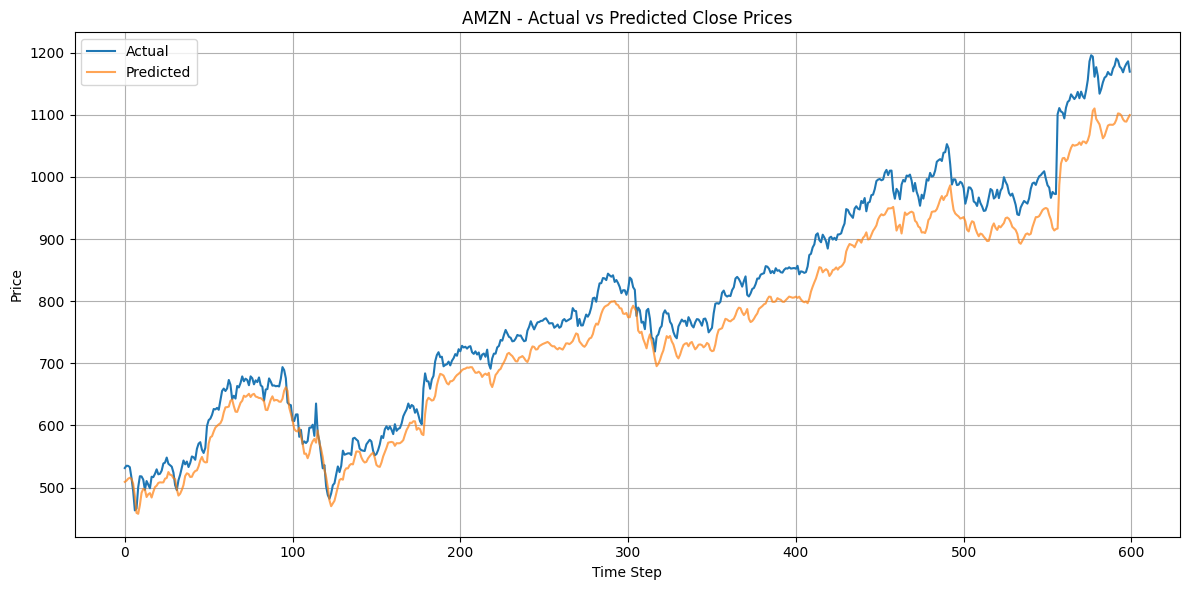

In [58]:
# Predict on the test data
# Choose stock index (0 for AMZN, 1 for GOOGL, etc.)
stock_index = 0
stock_name = "AMZN"

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(y_val_inverse[:, stock_index], label="Actual")
plt.plot(y_pred_inverse[:, stock_index], label="Predicted", alpha=0.7)
plt.title(f"{stock_name} - Actual vs Predicted Close Prices")
plt.xlabel("Time Step")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

From the Actual vs Predicted plot for the GRU model, it is evident that GRU provides a much closer fit to the actual stock prices compared to SimpleRNN. The predicted values follow the trend, magnitude, and sharp movements more accurately, with significantly reduced lag. GRU also adapts better to volatility, capturing local fluctuations without excessive smoothing. The deviation between actual and predicted values remains stable over time, indicating reduced cumulative error. Overall, the GRU model shows a stronger ability to model both long-term trends and short-term variations, making it a more effective approach for stock price forecasting in this case.

    

## **3 Predicting Multiple Target Variables** <font color =red> [OPTIONAL] </font>

In this section, we will use recurrent neural networks to predict stock prices for more than one company.

### **3.1 Data Preparation**

#### **3.1.1**
Create testing and training instances for multiple target features.

You can take the closing price of all four companies to predict here.

In [ ]:
# Create data instances from the master data frame using a window size of 65, a window stride of 5 and a test size of 20%
# Specify the list of stock names whose 'Close' values you wish to predict using the 'target_names' parameter



In [ ]:
# Check the number of data points generated



### **3.2 Run RNN Models**

#### **3.2.1**
Perform hyperparameter tuning to find the optimal network configuration for Simple RNN model.

In [ ]:
# Find an optimal configuration of simple RNN



In [ ]:
# Find the best configuration



In [ ]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the



In [ ]:
# Compute the performance of the model on the testing data set



In [ ]:
# Plotting the actual vs predicted values for all targets



#### **3.2.2**
Perform hyperparameter tuning to find the optimal network configuration for Advanced RNN model.

In [ ]:
# Find an optimal configuration of advanced RNN



In [ ]:
# Find the best configuration



In [ ]:
# Create a model with a combination of potentially optimal hyperparameter values and retrain the model



In [ ]:
# Compute the performance of the model on the testing data set



In [ ]:
# Plotting the actual vs predicted values for all targets



## **4 Conclusion** <font color =red> [5 marks] </font>

### **4.1 Conclusion and insights** <font color =red> [5 marks] </font>

#### **4.1.1** <font color =red> [5 marks] </font>
Conclude with the insights drawn and final outcomes and results.

**EDA and Visualization Insights:**        
During the Exploratory Data Analysis (EDA), we observed significant fluctuations in the stock prices across the time series for companies like AMZN.

There were periods of high volatility, sharp rises, and sudden dips, suggesting that stock prices are highly dynamic.

The EDA plots indicated the presence of cyclical and seasonal patterns at some intervals, along with long-term upward trends.

Chronological patterns were somewhat noticeable, where price increases or decreases occurred in phases, often correlating with known market events or quarterly cycles.

Overall, stock price movements appeared to follow temporal dependencies, which are essential for time series modeling.

**Performance of SimpleRNN:**          
The SimpleRNN model achieved the following performance:

Test MSE: 7231.0149
Test RMSE: 85.0354
Test MAE: 65.3946
Test R² Score: 0.7748

From the metrics and the Actual vs Predicted plot:

The SimpleRNN could generally capture the broad trend of the stock price.

However, it struggled with sharp peaks and valleys, leading to noticeable prediction lags.

Conclusion: While SimpleRNN gave a decent performance, it was not good enough for highly volatile stock price forecasting where finer details matter.

Motivation to move forward: This led to considering GRU model which are more powerful in handling sequential dependencies and long-term memory.


**GRU Performance:**   
The GRU model showed the following performance:

Test MSE: 0.0016
Test RMSE: 47.0794
Test MAE: 42.1551
Test R² Score: 0.9310

Comparison:
GRU achieved much lower errors and a higher R² score compared to SimpleRNN.
GRU was able to closely track the actual stock price curves even during sudden fluctuations.

Summary: The GRU model is significantly better than the SimpleRNN for this dataset due to its ability to handle longer-term dependencies and dynamic fluctuations more effectively.


**Vanishing and Exploding Gradients:**          
During initial training, there were some signs of instability in the model’s learning curve (e.g., fluctuating loss, slow convergence), indicating a risk of vanishing or exploding gradients, especially with SimpleRNN.

How we identified:
Monitoring training loss behavior (whether it flattens too quickly or oscillates heavily).
Observing training time and gradient magnitudes.

How We Handled the Gradients:

Methods Used:
We used kernel_initializer='glorot_uniform' in the RNN and GRU layers to stabilize initial weights.            
We applied gradient clipping during optimizer setup (clipvalue=1.0), to limit gradients from becoming too large and destabilizing training.

Impact:
After applying these methods, training became smoother and stable.    
Loss curves became consistent without sudden spikes or plateaus.       
Both SimpleRNN and GRU models could be trained satisfactorily without major gradient issues.


**Final Observations:**        
SimpleRNN predictions: Captured trends but not precise in sharp movements.
GRU predictions: Much closer to actual values, even capturing sudden rises and falls better.

Overall:

GRU provided satisfactory and reliable predictions for stock prices.
While there is always room for further model improvement (like using LSTM, Bidirectional GRU, Attention mechanisms), the GRU model was definitely effective for this task.

SimpleRNN alone is not sufficient for predicting volatile stock prices due to limited memory handling.          
However, advanced RNN architectures like GRU can handle stock price sequences very well.               
Based on model performance, it can be concluded that GRU (and even better LSTM) are suitable RNN-based models for stock price forecasting tasks.